In [ ]:
import json
import os
import shutil

import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

from flamingo.inference.inference import caption_from_file

/home/chris/miniconda3/envs/cc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chris/miniconda3/envs/cc/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/chris/miniconda3/envs/cc/lib/python3.11/site-package

In [2]:
# load audio
sr = 16000
y, sr = librosa.load("input.mp3", sr=sr)

### Caption

In [ ]:
# split into 10 second chunks
chunk_length = 10 * sr
num_chunks = len(y) // chunk_length
y_chunks = []
for i in range(num_chunks):
    start = i * chunk_length
    end = (i + 1) * chunk_length
    y_chunks.append(y[start:end])
for i, chunk in enumerate(y_chunks):
    if not os.path.exists("./flamingo/files_to_process"):
        os.makedirs("./flamingo/files_to_process")
    sf.write(f"./flamingo/files_to_process/chunk_{i}.wav", chunk, sr)

# create jsonl file for captioning with audio flamingo
caption_prompt = "Generate a descriptive caption for the following audio. Make sure to comment on its vibe/mood as a music piece"
lines = []
for i in range(num_chunks):
    lines.append(
        {
            "path": f"./flamingo/files_to_process/chunk_{i}.wav",
            "prompt": caption_prompt,
        }
    )
# write to jsonl file in ./flamingo/files_to_process/inference.jsonl
with open("./flamingo/files_to_process/inference.jsonl", "w", encoding="utf-8") as f:
    for line in lines:
        f.write(json.dumps(line) + "\n")
# caption
captions = caption_from_file("./flamingo/files_to_process/inference.jsonl")

# Define explicit fallback
default_caption = "Instrumental music passage"

# Process each caption
for i in range(len(captions)):
    if captions[i] in ["no response", "no caption", ""]:
        # First try previous caption
        if i > 0 and captions[i - 1] not in ["no response", "no caption", ""]:
            captions[i] = captions[i - 1]
        # Then try next caption
        elif i < len(captions) - 1 and captions[i + 1] not in [
            "no response",
            "no caption",
            "",
        ]:
            captions[i] = captions[i + 1]
        # Use default if no valid neighbors
        else:
            captions[i] = default_caption

# delete folder
shutil.rmtree("./flamingo/files_to_process")

### Major shifts

mfcc_increase: 12 changes
  Timestamps: [1.7919999999999998, 5.632, 11.648, 20.992, 56.064, 86.528, 93.44, 96.64, 104.832, 131.328, 132.352, 153.088]
mfcc_decrease: 6 changes
  Timestamps: [19.968, 24.32, 33.28, 75.52, 132.608, 154.368]
rms_increase: 7 changes
  Timestamps: [11.776000000000002, 66.944, 86.912, 93.44, 104.832, 113.536, 153.472]
rms_decrease: 9 changes
  Timestamps: [15.104, 19.712, 23.808, 55.168, 75.136, 88.06400000000001, 94.71999999999998, 139.52, 154.624]


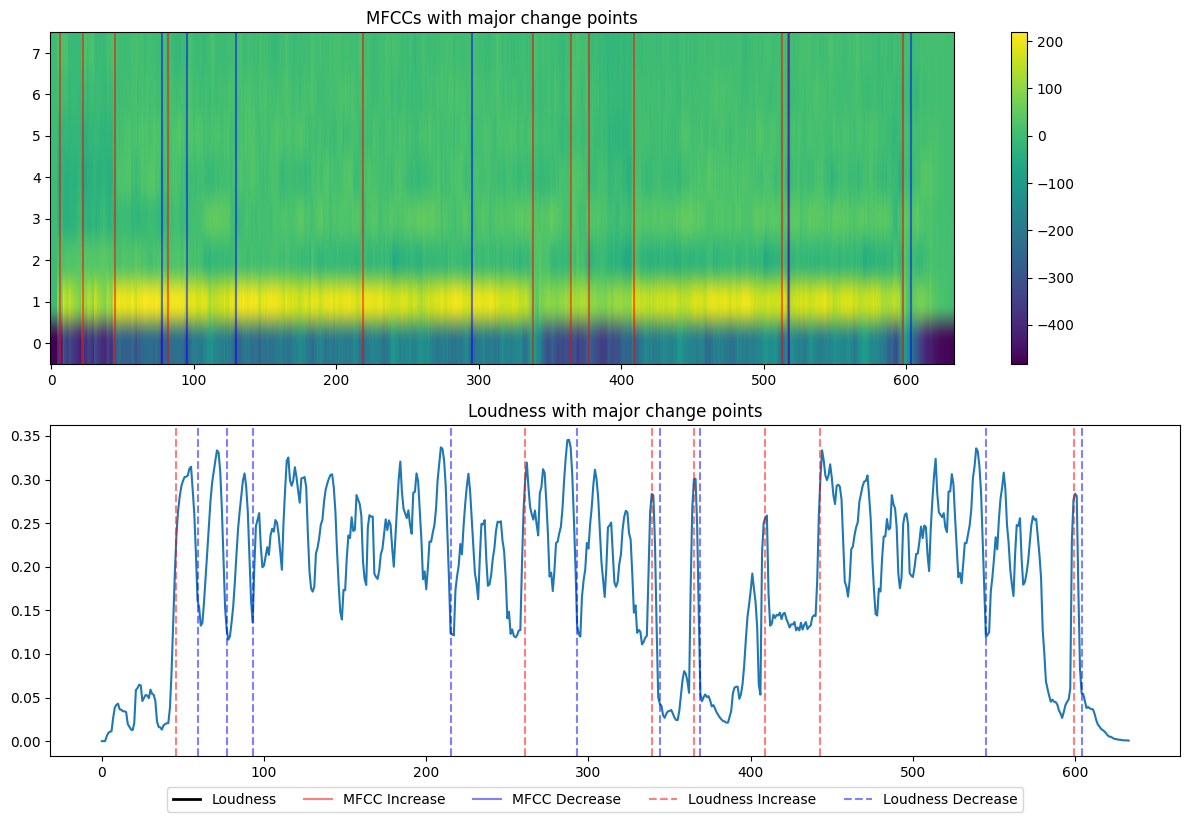

In [8]:
# get sequences of features over time
hop_length = 512 * 8  # Use consistent hop length
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8, hop_length=hop_length)
loudness = librosa.feature.rms(y=y, frame_length=2048 * 8, hop_length=hop_length)


# get major turn points in these features
def detect_significant_changes(mfccs, loudness, window_size=4):
    """
    Detects significant changes in MFCCs and loudness over time using a sliding window.
    Returns a dictionary with lists of timestamps for each change type.
    """
    # Dictionary to store timestamps by category - only major changes
    changes = {
        "mfcc_increase": [],
        "mfcc_decrease": [],
        "rms_increase": [],
        "rms_decrease": [],
    }

    # Define thresholds - only major thresholds
    major_mfcc_threshold = 25
    major_loudness_threshold = 0.15

    # Number of frames to analyze (minimum of both feature arrays)
    n_frames = min(mfccs.shape[1], loudness.shape[1])

    # Use a sliding window to detect changes
    for i in range(window_size, n_frames):
        # Calculate change in MFCCs
        mfcc_diff = np.mean(np.abs(mfccs[:, i] - mfccs[:, i - window_size]))
        mfcc_direction = np.mean(mfccs[:, i]) > np.mean(mfccs[:, i - window_size])

        # Track MFCC changes - only major changes
        if mfcc_diff > major_mfcc_threshold:
            timestamp = frame_to_time(i, sr, hop_length=hop_length)
            if mfcc_direction:
                changes["mfcc_increase"].append(timestamp)
            else:
                changes["mfcc_decrease"].append(timestamp)

        # Calculate change in loudness
        loudness_diff = np.abs(loudness[0, i] - loudness[0, i - window_size])
        loudness_direction = loudness[0, i] > loudness[0, i - window_size]

        # Track loudness (RMS) changes - only major changes
        if loudness_diff > major_loudness_threshold:
            timestamp = frame_to_time(i, sr, hop_length=hop_length)
            if loudness_direction:
                changes["rms_increase"].append(timestamp)
            else:
                changes["rms_decrease"].append(timestamp)

    # Consolidate nearby change points
    consolidated_changes = {}
    for category in changes.keys():
        consolidated_changes[category] = consolidate_timestamps(
            changes[category], time_threshold=1.0
        )

    # Also store the frame numbers for plotting purposes
    consolidated_changes["frames"] = {
        "mfcc_increase": [],
        "mfcc_decrease": [],
        "rms_increase": [],
        "rms_decrease": [],
    }

    # Convert timestamps back to frame numbers
    for category in consolidated_changes.keys():
        if category != "frames":
            consolidated_changes["frames"][category] = [
                time_to_frame(t, sr, hop_length=hop_length)
                for t in consolidated_changes[category]
            ]

    return consolidated_changes


def consolidate_timestamps(timestamps, time_threshold=1.0):
    """
    Group timestamps that are within time_threshold seconds of each other
    and return a single timestamp for each group (the average of the group).
    """
    if not timestamps:
        return []

    # Sort timestamps
    sorted_timestamps = sorted(timestamps)

    # Initialize result with the first timestamp
    consolidated = []
    current_group = [sorted_timestamps[0]]

    # Group timestamps that are close to each other
    for t in sorted_timestamps[1:]:
        if t - current_group[-1] <= time_threshold:
            # Add to current group
            current_group.append(t)
        else:
            # Finalize current group and start a new one
            consolidated.append(sum(current_group) / len(current_group))
            current_group = [t]

    # Add the last group
    if current_group:
        consolidated.append(sum(current_group) / len(current_group))

    return consolidated


def frame_to_time(frame_number, sr, hop_length=512 * 8):
    """Convert frame number to time in seconds."""
    return frame_number * hop_length / sr


def time_to_frame(time_sec, sr, hop_length=512 * 8):
    """Convert time in seconds to frame number."""
    return int(time_sec * sr / hop_length)


changes = detect_significant_changes(mfccs, loudness)

# Print the number of detected changes
for category, timestamps in changes.items():
    if category != "frames":
        print(f"{category}: {len(timestamps)} changes")
        if timestamps:
            print(f"  Timestamps: {timestamps}")

# Plot with color-coded change points
plt.figure(figsize=(12, 8))

# Plot MFCCs with change points
plt.subplot(2, 1, 1)
plt.title("MFCCs with major change points")
plt.imshow(mfccs, aspect="auto", origin="lower")
plt.colorbar()

# Add MFCC change markers
for frame in changes["frames"]["mfcc_increase"]:
    plt.axvline(x=frame, color="red", linestyle="-", alpha=0.5)
for frame in changes["frames"]["mfcc_decrease"]:
    plt.axvline(x=frame, color="blue", linestyle="-", alpha=0.5)

# Plot Loudness with change points
plt.subplot(2, 1, 2)
plt.title("Loudness with major change points")
plt.plot(loudness[0])

# Add RMS change markers
for frame in changes["frames"]["rms_increase"]:
    plt.axvline(x=frame, color="red", linestyle="--", alpha=0.5)
for frame in changes["frames"]["rms_decrease"]:
    plt.axvline(x=frame, color="blue", linestyle="--", alpha=0.5)

# Add a legend
custom_lines = [
    plt.Line2D([0], [0], color="black", lw=2),
    plt.Line2D([0], [0], color="red", linestyle="-", alpha=0.5),
    plt.Line2D([0], [0], color="blue", linestyle="-", alpha=0.5),
    plt.Line2D([0], [0], color="red", linestyle="--", alpha=0.5),
    plt.Line2D([0], [0], color="blue", linestyle="--", alpha=0.5),
]

plt.figlegend(
    custom_lines,
    [
        "Loudness",
        "MFCC Increase",
        "MFCC Decrease",
        "Loudness Increase",
        "Loudness Decrease",
    ],
    loc="lower center",
    ncol=5,
    bbox_to_anchor=(0.5, -0.03),
)

plt.tight_layout()
plt.show()


### Chord recognition

In [7]:
from chords.infer import predict_chords

print(predict_chords("input.mp3"))

ModuleNotFoundError: No module named 'utils'